<img alt="QuantRocket logo" src="https://www.quantrocket.com/assets/img/notebook-header-logo.png">

<a href="https://www.quantrocket.com/disclaimer/">Disclaimer</a>

# Listings by Dollar Volume

This notebook explores the number of listings by dollar volume for each country.

In [1]:
from quantrocket import get_prices
from quantrocket.account import download_exchange_rates
import pandas as pd
import io

Get exchange rates (for converting non-USD stocks to USD dollar volume):

In [2]:
f = io.StringIO()
download_exchange_rates(f, latest=True, base_currencies="USD")
rates = pd.read_csv(f)
rates = rates.set_index("QuoteCurrency").Rate.to_dict()

In [111]:
def get_mean_dollar_volumes(
    db,
    start_date, 
    universes=None):
    """
    Query database and return a Series of average USD dollar volume by conid. 
    """

    prices = get_prices(
        db, 
        start_date=start_date, 
        universes=universes, 
        fields=["Close","Volume"], 
        master_fields=["Currency","Multiplier","PriceMagnifier"])
        
    closes = prices.loc["Close"]
    volumes = prices.loc["Volume"]
    currencies = prices.loc["Currency"]
    multipliers = prices.loc["Multiplier"].reindex(closes.index, method="ffill")
    magnifiers = prices.loc["PriceMagnifier"].reindex(closes.index, method="ffill")
    exchange_rates = currencies.applymap(lambda x: rates[x])
    exchange_rates = exchange_rates.reindex(closes.index, method="ffill")
    closes = closes * multipliers.fillna(1) / magnifiers.fillna(1)
    dollar_volumes = closes.div(exchange_rates) * volumes
    avg_dollar_volumes = dollar_volumes.mean()

    return avg_dollar_volumes

Countries for which numbers should be run:

In [64]:
countries = (
    # North America
    ("usa-stk-1d", "United States"),
    ("canada-stk-1d", "Canada"),
    ("mexico-stk-1d", "Mexico"),
    
    # Asia
    ("australia-stk-1d", "Australia"),
    ("japan-stk-1d", "Japan"),
    ("hongkong-stk-1d", "Hong Kong"),
    ("singapore-stk-1d", "Singapore"),
    
    # Europe
    ("spain-stk-1d", "Spain"),
    ("netherlands-stk-1d", "Netherlands"),
    ("uk-stk-1d", "United Kingdom"),
    ("germany-stk-1d", "Germany"),
    ("france-stk-1d", "France"),
    ("belgium-stk-1d", "Belgium"),
    ("swiss-stk-1d", "Switzerland"),
    ("austria-stk-1d", "Austria"),
    ("sweden-stk-1d", "Sweden"),
    ("italy-stk-1d", "Italy"),
)

Run numbers for each country:

In [65]:
all_countries = {}
start_date = "2018-01-01"

for db, country in countries:
    print(country)
    dollar_volumes = get_mean_dollar_volumes(db, start_date)
    all_countries[country] = dollar_volumes

United States
Canada
Mexico
Australia
Japan
Hong Kong
Singapore
Spain
Netherlands
United Kingdom
Germany
France
Belgium
Switzerland
Austria
Sweden
Italy


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set(palette=sns.color_palette("Blues_d", n_colors=1))

In [112]:
def get_listings_above(threshold):
    """
    Returns counts of listings per country which are above the dollar volume threshold.
    """
    listings = {}
    for country, dollar_volumes in all_countries.items():
        listings[country] = dollar_volumes[dollar_volumes>=threshold].count()
        
    listings = pd.Series(listings)
    return listings

In [105]:
def plot_counts(listings, title, tick_spacing=100):
    """
    Plot listing counts by country.
    """
    sns.set(palette=sns.color_palette("Blues_d", n_colors=1))
    xmax = math.ceil(listings.max()/100) * 100 + 100
    ax = listings.sort_values().plot(kind="barh", title=title, figsize=(16,6), xticks=list(range(0, xmax, tick_spacing)))
    plt.xticks(rotation=90)
    ax.set_xlabel("Number of listings")

In [104]:
def plot_us_vs_world(listings, title):
    """
    Plot US listings vs the rest of the world.
    """
    sns.set(palette=sns.color_palette("Blues_d", n_colors=2))
    us_v_world = pd.Series(
        [listings.loc["United States"], 
         listings.loc[listings.index != "United States"].sum()], 
        index=["United States", "Rest of World"], name="Percentage of total")
    us_v_world.plot(kind="barh", title=title, figsize=(16,2))

Plot listing counts above various thresholds:

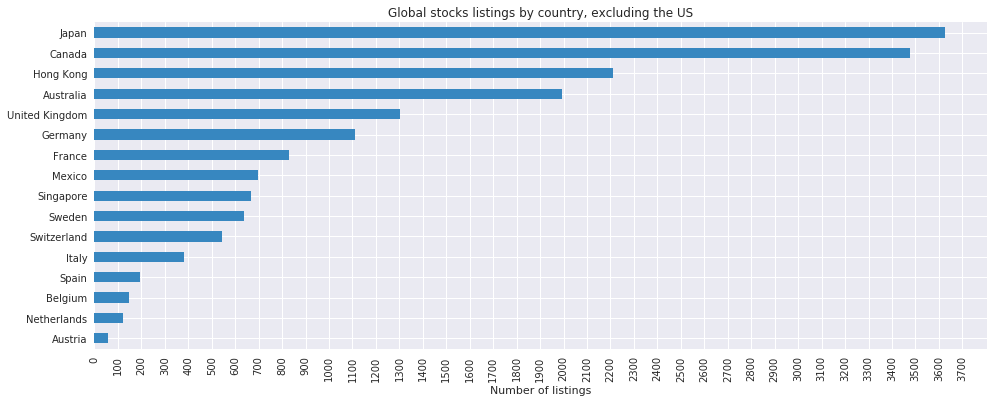

In [109]:
listings = get_listings_above(0)
plot_counts(listings[listings.index != "United States"], "Global stocks listings by country, excluding the US")

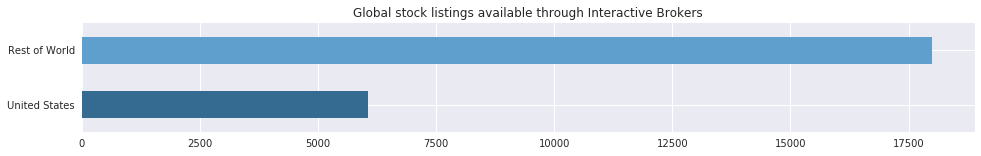

In [94]:
plot_us_vs_world(listings, title="Global stock listings available through Interactive Brokers")

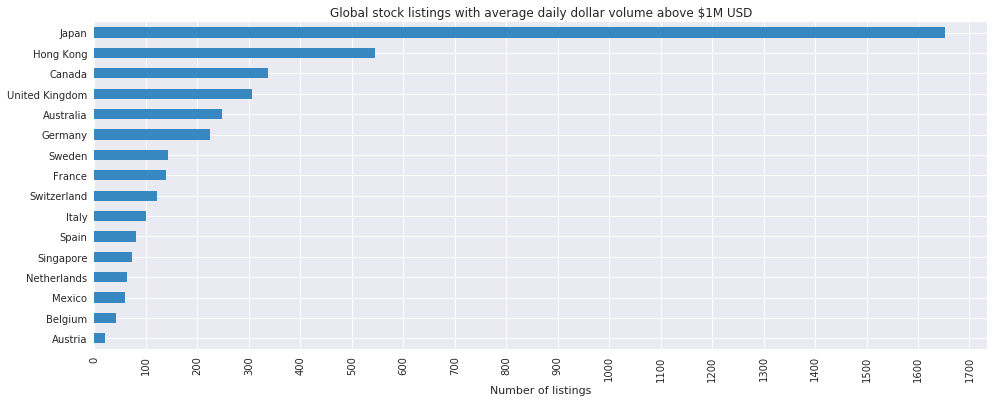

In [110]:
listings = get_listings_above(1000000)
plot_counts(listings[listings.index != "United States"], "Global stock listings with average daily dollar volume above $1M USD")

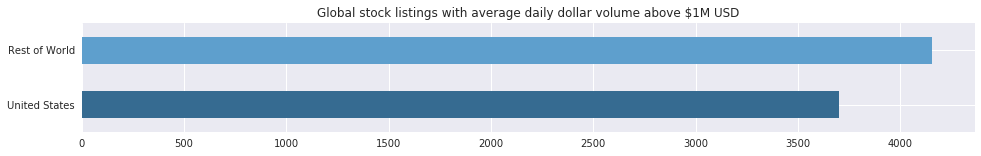

In [101]:
plot_us_vs_world(listings, "Global stock listings with average daily dollar volume above $1M USD")

***

[Back to Introduction](Introduction.ipynb)